# Spindles analysis

## Introductory notes:
This notebook presents spindles detection and analysis functionality.

Recommended reading:
1. [YASA: FAQ](https://raphaelvallat.com/yasa/build/html/faq.html#event-detection)
2. [YASA: Spindles detection on specific sleep stages](https://github.com/raphaelvallat/yasa/blob/master/notebooks/03_spindles_detection_NREM_only.ipynb)
3. [YASA: SpindlesResults class](https://raphaelvallat.com/yasa/build/html/generated/yasa.SpindlesResults.html#yasa.SpindlesResults)
4. [MNE: Time-frequency analysis: power and inter-trial coherence](https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html#time-frequency-analysis-power-and-inter-trial-coherence)
5. [MNE: AverageTFR class](https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html#mne-time-frequency-averagetfr)

## Import module

In [ ]:
from sleepeegpy.pipeline import SpindlesPipe
from joblib import parallel_backend; parallel_backend("loky", n_jobs=-1)
from os import makedirs,path

## Spindles detection

If you wish to change the path for output_dir ot input dir, change it below.
If no such folders, they will be created automatically.

In [ ]:
output_dir  = "output_folder" # Output path and name can be changed here
input_dir = "input_files" # input files dir can be changed here
makedirs(input_dir, exist_ok=True)
makedirs(output_dir, exist_ok=True)

#### Add required files and data
* Put all your files in the input folder.
* Modify your eeg file name below. The file can be any format supported by the mne.read_raw() function.
* Modify your hypnogram file name below
* Make sure the hypno_freq is the right frequency.
* For more information about the supported formats, see [mne documentation](https://mne.tools/stable/generated/mne.io.Raw.html)

In [ ]:
eeg_file_name= "resampled_raw.fif" # add your eeg_path here
hypnogram_filename = "staging.txt" # Hypnogram filename can be changed here (file must be in the input dir)
hypno_freq = 1

In [ ]:
path_to_eeg = path.join(input_dir,eeg_file_name)
hypnogram_path = path.join(input_dir,hypnogram_filename)
spindles_pipe = SpindlesPipe(
    path_to_eeg=path_to_eeg,
    output_dir=output_dir,
    path_to_hypno=hypnogram_path,
    hypno_freq=hypno_freq,
)

Please refer to the YASA's [documentation](https://raphaelvallat.com/yasa/build/html/generated/yasa.spindles_detect.html) for details about the arguments.

In [ ]:
spindles_pipe.detect(
    picks=["eeg"],
    reference="average",
    include=(2, 3),
    freq_sp=(12, 15),
    freq_broad=(1, 30),
    duration=(0.5, 2),
    min_distance=500,
    thresh={"corr": 0.65, "rel_pow": 0.2, "rms": 1.5},
    multi_only=False,
    remove_outliers=False,
    verbose=False,
    save=True,
)

Please refer to the YASA's [documentation](https://raphaelvallat.com/yasa/build/html/generated/yasa.SpindlesResults.html#yasa.SpindlesResults.summary) for details about the arguments.

In [ ]:
spindles_pipe.results.summary(
    grp_chan=False, grp_stage=True, mask=None, aggfunc="mean", sort=True
)

,Count,Density,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Stage,,,,,,,,,,
2,48125,439.497717,0.802510,35.844591,7.849986,1.739719,0.402655,13.149206,10.165049,0.513328
3,22294,116.722513,0.751883,40.712861,9.045872,1.862345,0.384414,13.194922,9.552705,0.516585


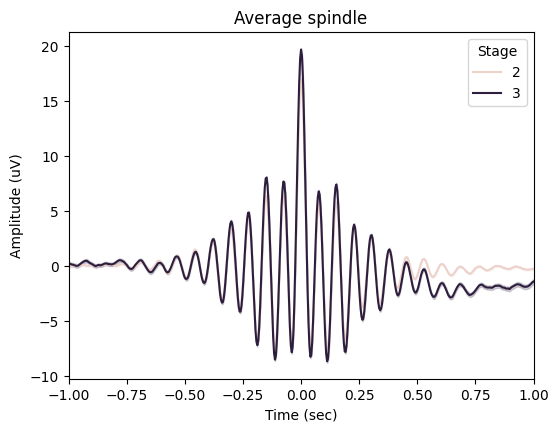

In [ ]:
spindles_pipe.plot_average(
    save=True,
    center="Peak",
    hue="Stage",
    time_before=1,
    time_after=1,
    filt=(None, None),
    mask=None,
)

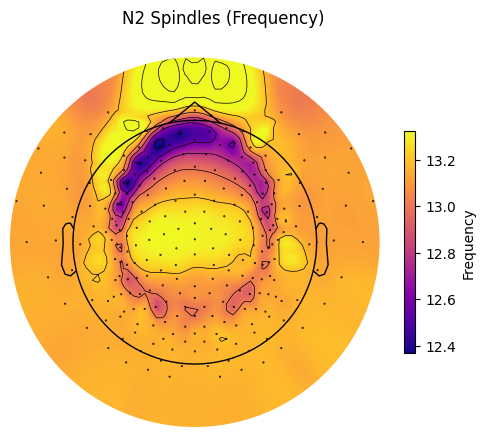

In [ ]:
spindles_pipe.plot_topomap(
    prop="Frequency",  #  Any of the event properties returned by pipe.results.summary().
    stage="N2",  # Stage to plot the topomap for.
    aggfunc="mean",  # Aggregation function for channel grouping.
    # Should contain at least index of the provided "stage".
    sleep_stages={"Wake": 0, "N1": 1, "N2": 2, "N3": 3, "REM": 4},
    axis=None,  # Whether to plot on provided matplotlib axis.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)

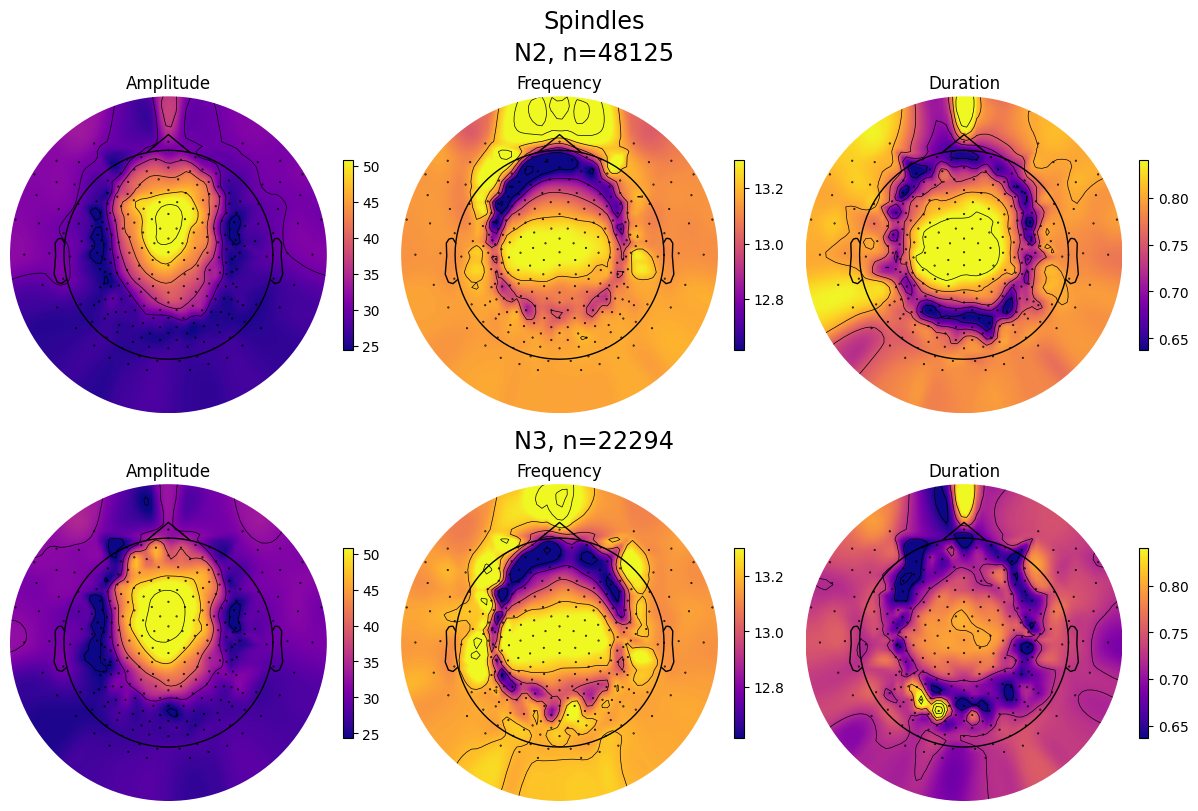

In [ ]:
spindles_pipe.plot_topomap_collage(
    # Some of the event properties returned by pipe.results.summary().
    props=["Amplitude", "Frequency", "Duration"],
    aggfunc="mean",  # Aggregation function for channel grouping.
    # Tuple of strs or "all", e.g., ("N1", "REM") or "all" (plots all "sleep_stages").
    stages_to_plot="all",
    # Should contain at least indices of the provided "stages_to_plot".
    sleep_stages={"N2": 2, "N3": 3},
    low_percentile=5,  # Set min color value by percentile of the property data.
    high_percentile=95,  # Set max color value by percentile of the property data.
    fig=None,  # Instance of plt.Figure, a new fig will be created if None.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)

Constructs MNE [AverageTFR](https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html) object for every available sleep stage.

In [ ]:
spindles_pipe.compute_tfr(
    freqs=(10, 20),  # Interval of frequencies of interest.
    n_freqs=100,  # TFR frequency resolution.
    time_before=1,  # Time in sec before the peak to use in TFR computation. Should be positive.
    time_after=1,  # Time in sec after the peak to use in TFR computation.
    method="morlet",  # TFR method: 'morlet' or 'multitaper'.
    save=True,  # Whether to save AverageTFR object per sleep stage as hdf5 file.
    overwrite=False,  # Whether to overwrite existing files.
)

spindles_pipe.tfrs

In [ ]:
spindles_pipe.tfrs["N2"].data

array([[[165.44385771, 169.92036454, 174.23956786, ..., 251.72769742,
         245.62927484, 239.30345075],
        [163.99052483, 168.49114899, 172.83396985, ..., 247.9999998 ,
         241.99269192, 235.75219132],
        [162.56633576, 167.09405193, 171.46393358, ..., 244.37907057,
         238.45905738, 232.30020575],
        ...,
        [ 46.16793334,  47.01757305,  47.5113704 , ...,  63.95819156,
          63.84737753,  63.19868073],
        [ 45.74479396,  46.57959889,  47.0574021 , ...,  63.33866633,
          63.24374934,  62.61033302],
        [ 45.3302599 ,  46.15072422,  46.61304951, ...,  62.73090346,
          62.65140487,  62.03282812]],

       [[183.03852542, 188.05132799, 192.90103697, ..., 362.26134796,
         352.15546474, 341.75556073],
        [179.36273518, 184.3038714 , 189.08251403, ..., 354.76061295,
         344.79643891, 334.54188686],
        [175.76023984, 180.63134178, 185.34100882, ..., 347.22249221,
         337.41589585, 327.32177991],
        ...,


In [ ]:
spindles_pipe.tfrs["N2"].to_data_frame()

,time,freq,E1,E10,E100,E101,E102,E103,E104,E105,...,E91,E92,E93,E94,E95,E96,E97,E98,E99,VREF
0,-1.000,10.0,165.443858,183.038525,357.247596,407.714768,367.061131,403.271235,439.417678,457.963162,...,191.327237,191.225602,181.691803,208.996170,198.116414,177.822697,192.377679,169.344080,137.058994,431.558397
1,-0.996,10.0,169.920365,188.051328,368.793126,421.133352,377.604580,416.300607,454.302290,473.374693,...,197.382219,197.558606,188.066255,215.492143,204.044079,183.797165,198.590959,175.259107,142.024406,445.426355
2,-0.992,10.0,174.239568,192.901037,380.086587,434.450949,387.836302,429.071681,468.968133,488.561540,...,203.319116,203.775189,194.335510,221.796086,209.799195,189.672437,204.685274,181.083009,146.922135,459.071033
3,-0.988,10.0,178.391438,197.575344,391.093778,447.647728,397.730075,441.553881,483.380503,503.488717,...,209.123305,209.858019,200.480026,227.885826,215.364812,195.433170,210.645100,186.798909,151.736835,472.466480
4,-0.984,10.0,182.367373,202.063155,401.782197,460.704946,407.262053,453.719253,497.506821,518.123475,...,214.781062,215.790568,206.480974,233.740487,220.725338,201.064896,216.455858,192.390601,156.453546,485.589296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50095,0.984,20.0,61.349063,65.048047,85.063819,113.433422,88.394031,124.506086,149.952411,121.336701,...,42.527688,66.486529,41.358480,43.371996,44.445922,38.431979,55.741899,38.668228,32.639920,133.629536
50096,0.988,20.0,62.286521,66.031386,87.079793,115.201462,89.856116,126.484048,152.059416,121.359426,...,42.937436,67.461370,41.915039,43.619696,45.178900,38.646578,56.871620,39.109777,32.910099,133.434442
50097,0.992,20.0,62.730903,66.501097,88.450080,116.113594,90.658314,127.473423,152.945087,120.539369,...,43.032323,67.901196,42.151561,43.561366,45.569074,38.588749,57.545199,39.264615,32.936681,132.337261
50098,0.996,20.0,62.651405,66.423002,89.105845,116.103670,90.741003,127.405634,152.538994,118.845436,...,42.792571,67.772755,42.045046,43.179045,45.587985,38.243719,57.726269,39.112192,32.705906,130.307051


No baseline correction applied


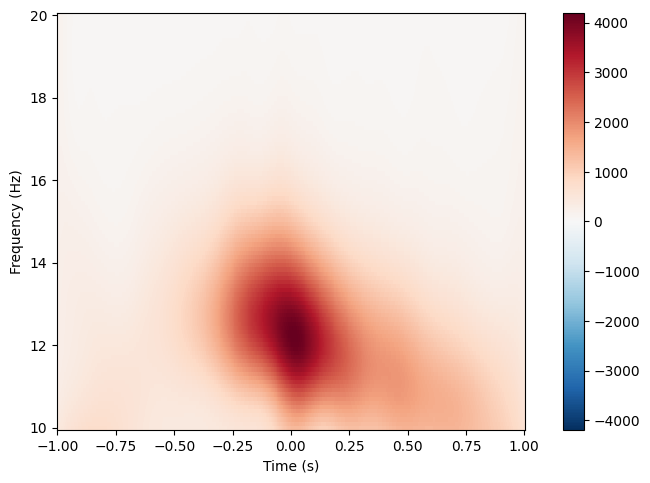

No baseline correction applied


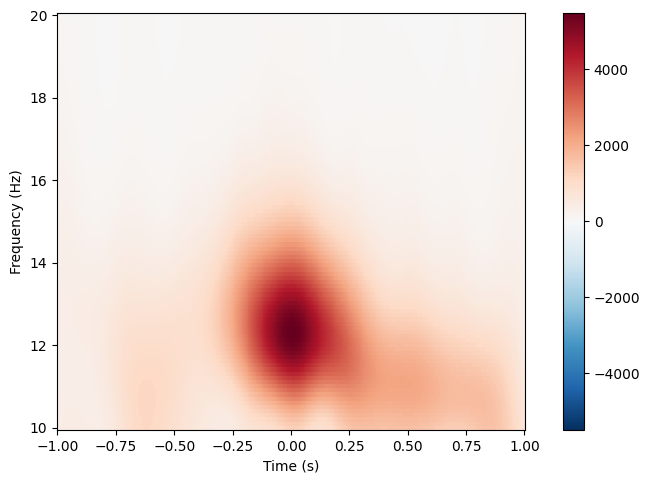

[<Figure size 640x480 with 2 Axes>]

In [ ]:
spindles_pipe.tfrs["N2"].plot(["E101"]),
spindles_pipe.tfrs["N3"].plot(["E101"])

If you want to load saved TFR files:

In [ ]:
spindles_pipe.read_tfrs(dirpath=None)